### Morris sensitivity analysis

Morris sensitivity analysis for tabular data based on the SALib. If using this explainer, please cite the package: https://github.com/SALib/SALib. This explainer only supports continuous-valued features.

In [1]:
import sys
import os

module_path = os.path.abspath('E:/Codes/OmniXAI/')
if module_path not in sys.path:
    sys.path.append(module_path)

# For Jupyter notebooks or interactive environments where __file__ is not defined
try:
    # Try to use __file__ if available
    directory = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # If __file__ is not defined (e.g., in Jupyter), use the current working directory
    directory = os.path.abspath('')
    
sys.path.append(os.path.dirname(directory))

In [2]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [4]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
from sklearn.datasets import fetch_california_housing

from omnixai.data.tabular import Tabular
from omnixai.preprocessing.base import Identity
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import SensitivityAnalysisTabular

We recommend using `Tabular` to represent a tabular dataset, which can be constructed from a pandas dataframe or a numpy array. To create a `Tabular` instance given a pandas dataframe, one needs to specify the dataframe, the categorical feature names (if exists) and the target/label column name (if exists).

In [5]:
california = fetch_california_housing()
df = pd.DataFrame(
    np.concatenate([california.data, california.target.reshape((-1, 1))], axis=1),
    columns=list(california.feature_names) + ['target'])
# California housing dataset has no categorical features to remove
tabular_data = Tabular(df, target_column='target')

We train a random forest model for this regression task.

In [6]:
transformer = TabularTransform(
    target_transform=Identity()
).fit(tabular_data)
x = transformer.transform(tabular_data)

x_train, x_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.80)
print('Training data shape: {}'.format(x_train.shape))
print('Test data shape:     {}'.format(x_test.shape))

rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)
rf.fit(x_train, y_train)
print('Random Forest MSError', np.mean((rf.predict(x_test) - y_test) ** 2))

Training data shape: (16512, 8)
Test data shape:     (4128, 8)
Random Forest MSError 0.26302356372614183


To initialize a sensitivity analyzer, we need to set:
  
  - `training_data`: The data used to initialize the explainer. ``training_data`` can be the training dataset for training the machine learning model. If the training dataset is too large, ``training_data`` can be a subset of it by applying `omnixai.sampler.tabular.Sampler.subsample`.
  - `predict_function`: The prediction function corresponding to the model.

In [8]:
predict_function = lambda z: rf.predict(transformer.transform(z))
explainer = SensitivityAnalysisTabular(
    training_data=tabular_data,
    predict_function=predict_function,
)

`SensitivityAnalysisTabular` generates global explanations by calling `explain`. `ipython_plot` shows the generated explanations in IPython.

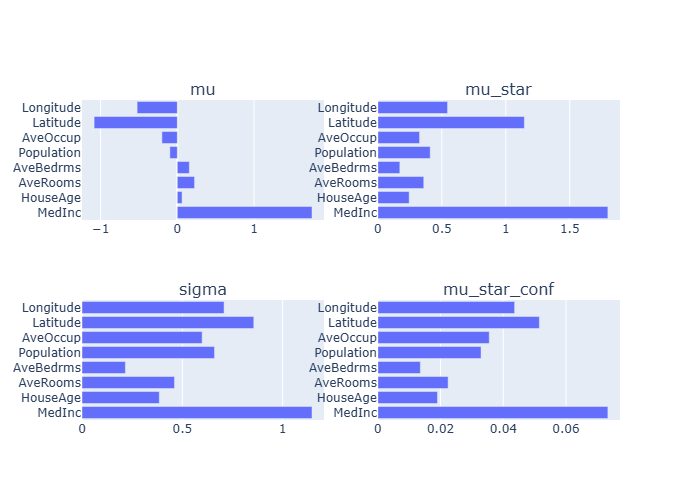

In [9]:
explanations = explainer.explain()
explanations.ipython_plot()